# UC Berkeley Extension Data Analytics Program

## Project 1: How To Win in the NBA



#### Team members: Aaron Chen, Alejandro Montesinos, Christian De Vera and Zane Brown

Date: April 4, 2019

## Summary

In this study we analyze what factors contribute to winning games in the NBA. To answer this question, we collected data on NBA statistics from the last 5 seasons form two data sources. From Basketball Reference we got on several statistics at team level (macro). From NBA.com we collected data on shots taken broken down by distance from the hoop (micro).

This notebook is organized as follows:
- Section 1: Data cleaning
- Section 2: The impact of 3-point Shooting
- Section 3: Does Defense Win Games?
- Section 4: Team Performance Influence on Winning 
- Section 5: Modern Day NBA Offenses: More 3s, less mid range shots


In [1]:
# Import Dependencies
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from scipy                 import stats
from scipy.stats           import linregress
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

## 1. Data Cleaning

In [2]:
#Define Years included in the analysis
years = [2014, 2015, 2016,2017, 2018]

In [3]:
#Read in yearly CSV from Basketball reference and stack them together

df_list      = {}   #Dictionary to store yearly data frames
misc_varlist = ["Team", "W","Age","ORtg","DRtg","Pace"]
ph_varlist   = ["Team","ph_FG","ph_FGA","ph_FGpct","ph_3P","ph_3Ppct","ph_2P","ph_2PA",
                "ph_2Ppct","ph_FT","ph_FTA","ph_FTpct","ph_ORB","ph_DRB","ph_TRB","ph_AST",
                "ph_STL","ph_BLK","ph_TOV","ph_PF"]

for y in years:
    season = f"{y-1}_{y}"
    stat_csv   = f"raw_data/{season}_nba.csv"         #regular season file name
    misc_csv   = f"raw_data/misc_{season}_nba.csv"    #miscellaneous file name
    per100_csv = f"raw_data/per100_{season}_nba.csv"  #Per 100 possessions file name
    a = pd.read_csv("./"+stat_csv)                    #Read in regular season data
    b = pd.read_csv("./"+misc_csv)                    #Read in miscellaneous data                    
    c = pd.read_csv("./"+per100_csv)                  #Read in per 100 possessions data    
    c = c.rename(columns={"FG":"ph_FG","FGA":"ph_FGA","FG%":"ph_FGpct","3P":"ph_3P","3P%":"ph_3Ppct","2P":"ph_2P","2PA":"ph_2PA","2P%":"ph_2Ppct","FT":"ph_FT","FTA":"ph_FTA","FT%":"ph_FTpct","ORB":"ph_ORB","DRB":"ph_DRB","TRB":"ph_TRB","AST":"ph_AST","STL":"ph_STL","BLK":"ph_BLK","TOV":"ph_TOV","PF": "ph_PF"})
    b = b[misc_varlist]
    c = c[ph_varlist]    
    a["Team"] = a["Team"].str.replace(r"*", "")
    b["Team"] = b["Team"].str.replace(r"*", "")
    c["Team"] = c["Team"].str.replace(r"*", "")
    dfname = f"nba_{season}_df"                                #Set name of yearly data frame
    d = pd.merge(a, b, on="Team", how="left")                  #Merge season and miscellanoeous data
    df_list[dfname] = pd.merge(d, c, on="Team", how="left")    #Add per 100 possession stats
    df_list[dfname]["Year"] = y                                #Create year variable
        
stacked_df = pd.concat(df_list.values(), ignore_index=True)    #Stack all yearly dataframes together
stacked_df.head()

,Rk,Team,G,MP,FG,FGA,FG%,3P,3PA,3P%,...,ph_FTpct,ph_ORB,ph_DRB,ph_TRB,ph_AST,ph_STL,ph_BLK,ph_TOV,ph_PF,Year
0,1.0,Los Angeles Clippers,82,240.9,39.1,82.5,0.474,8.5,24.0,0.352,...,0.730,10.9,33.8,44.6,25.5,8.9,5.0,14.4,22.4,2014
1,2.0,Houston Rockets,82,241.8,38.0,80.5,0.472,9.5,26.6,0.358,...,0.712,11.6,35.1,46.7,22.1,7.8,5.8,16.6,21.1,2014
2,3.0,Minnesota Timberwolves,82,242.1,38.9,87.5,0.444,7.3,21.4,0.341,...,0.778,12.7,32.8,45.6,24.4,8.9,3.7,14.2,18.7,2014
3,4.0,Portland Trail Blazers,82,242.1,39.1,87.0,0.450,9.4,25.3,0.372,...,0.815,13.0,35.5,48.5,24.3,5.8,4.9,14.3,20.1,2014
4,5.0,Oklahoma City Thunder,82,241.5,39.0,82.7,0.471,8.1,22.4,0.361,...,0.806,11.3,35.3,46.6,22.8,8.6,6.4,15.9,23.6,2014


In [4]:
### GET ANALYTICAL DATASET ###

#Drop the League Average row as we're only interested in Teams
stacked_df=stacked_df[stacked_df.Team != "League Average"]
stacked_df=stacked_df.reset_index(drop=True)
#Drop Ranking variable
stacked_df=stacked_df.drop(["Rk"], axis=1)
#Compute Winning Percentage
stacked_df["PctWin"] = (stacked_df["W"]/stacked_df["G"])*100
#Compute Missed Shots
stacked_df["ph_shotmisspct"] = ((stacked_df["ph_FGA"]+stacked_df["ph_FTA"])-(stacked_df["ph_FG"]+stacked_df["ph_FT"]))/(stacked_df["ph_FGA"]+stacked_df["ph_FTA"])
#Compute Total Shots (2 and 3 points)
stacked_df["Shots"]=stacked_df["2PA"]+stacked_df["3PA"]
#Compute 3-points to Total shots ratio 
stacked_df["3PA/Shots"]=(stacked_df["3PA"]/stacked_df["Shots"])*100
#Format percentage variables
stacked_df["2P%"]=stacked_df["2P%"]*100
stacked_df["3P%"]=stacked_df["3P%"]*100

#Print and output final dataset
stacked_df.head()
stacked_df.to_csv("./Output_data/nba_data.csv")

In [5]:
# Work on Mid-Range data from NBA.com
mdrdf_list = {} 
locdf_list = {} 
advdf_list = {} 

for y in years:
    midr_csv = f"raw_data/leaguedashteamstats_{y}.csv"
    loca_csv = f"raw_data/leaguedashteamshotlocations_{y}.csv"
    advc_csv = f"raw_data/advancedteamstats_{y}.csv"
    
    #Mid-Range data
    a = pd.read_csv("./"+midr_csv)
    a["Year"] = f"{y}"
    a[" TEAM_NAME"] = a["Year"].map(str) + a[" TEAM_NAME"]
    a = a[[" TEAM_NAME"," PCT_PTS_2PT_MR"]]
    a_dfnm = f"mid_range_{y}" 
    mdrdf_list[a_dfnm] = a
    
    #Locations data
    b = pd.read_csv("./"+loca_csv)
    b["MID FGA/FGA"] = (b[" MID_FGA"]/(b[" RA_FGA"] + b[" P_FGA"] + b[" MID_FGA"] + b[" L3_FGA"] + b[" R3_FGA"] + b[" A3_FGA"]))
    b["LA MID FGA/FGA"] = b["MID FGA/FGA"].mean()
    b["Year"] = f"{y}"
    b[" TEAM_NAME"] = b["Year"].map(str) + b[" TEAM_NAME"]
    b = b[[" TEAM_NAME", " MID_FGA", "MID FGA/FGA", "LA MID FGA/FGA"]]
    b_dfnm = f"loca_{y}" 
    locdf_list[b_dfnm] = b
    
    #advanced Stats
    c = pd.read_csv("./"+advc_csv)
    c["League Average OffRating"] = c[" OFF_RATING"].mean()
    c["Year"] = f"{y}"
    c[" TEAM_NAME"] = c["Year"].map(str) + c[" TEAM_NAME"]
    c = c[[" TEAM_NAME", " OFF_RATING", " EFG_PCT", " TS_PCT", "League Average OffRating"]]
    c_dfnm = f"adv_{y}" 
    advdf_list[c_dfnm] = c
    

In [6]:
#Stack and sort Mid Range
mid_range_df = pd.concat(mdrdf_list.values(), ignore_index=True)    #Stack all yearly dataframes together
sorted_mid_range_df = mid_range_df.sort_values([" PCT_PTS_2PT_MR"], ascending=False)
sorted_mid_range_df.head()

,TEAM_NAME,PCT_PTS_2PT_MR
49,2015 New York Knicks,0.253
33,2015 Charlotte Hornets,0.238
79,2016 New York Knicks,0.235
59,2015 Washington Wizards,0.233
21,2014 Orlando Magic,0.226


In [7]:
#Stack and sort Location data
location_df = pd.concat(locdf_list.values(), ignore_index=True)
sorted_location_df = location_df.sort_values(["MID FGA/FGA"], ascending=False)
sorted_location_df.head()

,TEAM_NAME,MID_FGA,MID FGA/FGA,LA MID FGA/FGA
49,2015 New York Knicks,29.1,0.355746,0.262125
59,2015 Washington Wizards,28.9,0.350303,0.262125
47,2015 Minnesota Timberwolves,28.9,0.347774,0.262125
43,2015 Los Angeles Lakers,29.2,0.341520,0.262125
33,2015 Charlotte Hornets,28.6,0.338863,0.262125


In [8]:
#Stack and sort Advanced data
advanced_df = pd.concat(advdf_list.values(), ignore_index=True)
sorted_advanced_df = advanced_df.sort_values([" EFG_PCT"], ascending=False)
sorted_advanced_df.head()

,TEAM_NAME,OFF_RATING,EFG_PCT,TS_PCT,League Average OffRating
129,2018 Golden State Warriors,112.7,0.569,0.603,107.736667
69,2016 Golden State Warriors,113.4,0.563,0.593,105.536667
99,2017 Golden State Warriors,114.8,0.563,0.597,108.143333
15,2014 Miami Heat,110.0,0.554,0.590,105.660000
130,2018 Houston Rockets,114.0,0.551,0.590,107.736667


## 2. The impact of 3-point Shooting

In [9]:
#Evolution of 3P shooting over time
nba_3PA_year=stacked_df.groupby("Year").mean()
nba_3PA_year=nba_3PA_year[["3PA"]]
nba_3PA_year

,3PA
Year,
2014,21.536667
2015,22.410000
2016,24.083333
2017,27.003333
2018,28.996667


<IPython.core.display.Javascript object>


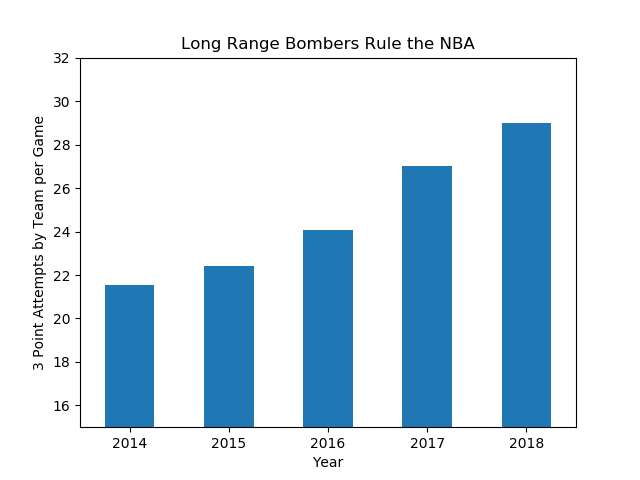

In [10]:
#Long Range graph
%matplotlib notebook

nba_3PA_year.plot(kind="bar", title="Long Range Bombers Rule the NBA",legend=False)
plt.ylabel("3 Point Attempts by Team per Game")
plt.ylim(15, 32)
plt.xticks(rotation=0)
plt.savefig("./Figures/S2F1_LongRange.png")
plt.show()

In [11]:
#Evolution of 3P shooting over time
nba_3PS_year=stacked_df.groupby("Year").mean()
nba_3PS_year=nba_3PS_year[["3PA/Shots"]]
nba_3PS_year

,3PA/Shots
Year,
2014,25.957978
2015,26.790529
2016,28.450358
2017,31.628534
2018,33.710230


<IPython.core.display.Javascript object>


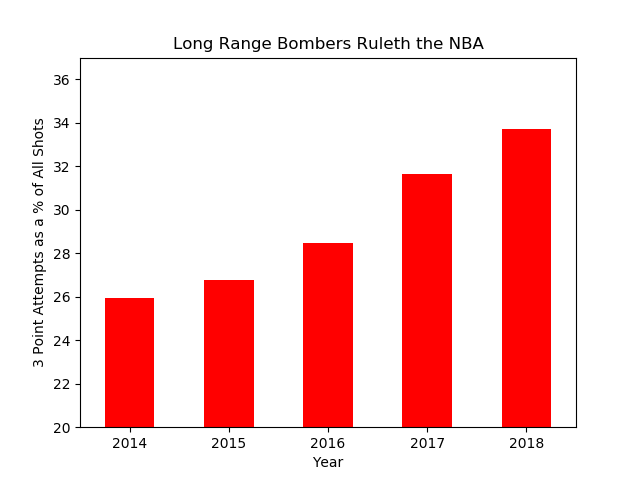

In [12]:
#Percent Shots over time
%matplotlib notebook

nba_3PS_year.plot(kind="bar", title="Long Range Bombers Ruleth the NBA", color="red", legend=False)
plt.ylabel("3 Point Attempts as a % of All Shots")
plt.ylim(20, 37)
plt.xticks(rotation=0)
plt.savefig("./Figures/S2F2_3PA_Percent_Shots.png")
plt.show()

In [13]:
#Get 2-point and 3-point shooting percentage overtime
nba_3PA_2PA_year=stacked_df.groupby("Year").mean()
nba_3PA_2PA_year=nba_3PA_2PA_year[["2P%","3P%"]]
nba_3PA_2PA_year.reset_index(inplace=True)
nba_3PA_2PA_year

,Year,2P%,3P%
0,2014,48.853333,35.876667
1,2015,48.576667,34.910000
2,2016,49.163333,35.276667
3,2017,50.396667,35.716667
4,2018,51.076667,36.173333


<IPython.core.display.Javascript object>


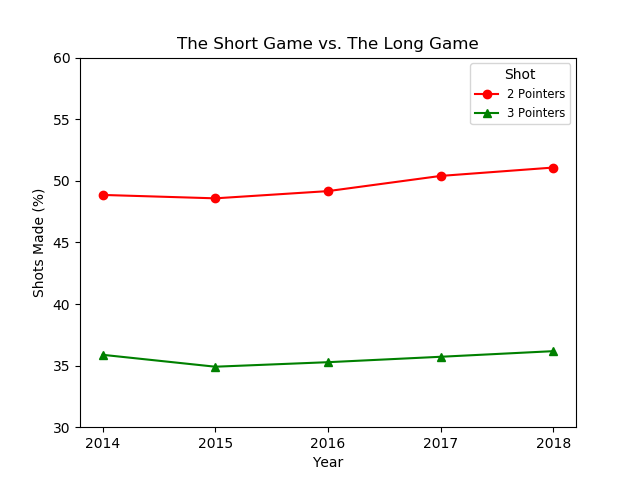

In [14]:
#Graph 2-point shooting and 3-point shooting over time
%matplotlib notebook

x_axis  = nba_3PA_2PA_year["Year"]
points_2= nba_3PA_2PA_year["2P%"]
points_3= nba_3PA_2PA_year["3P%"]

points_2_handle = plt.plot(x_axis, points_2, marker ='o', color='red'  , label="2 Pointers")
points_3_handle = plt.plot(x_axis, points_3, marker='^' , color='green', label="3 Pointers")

legend = plt.legend(fontsize="small", mode="Expanded", title="Shot", labelspacing=0.5)

plt.title("The Short Game vs. The Long Game")
plt.xlabel("Year")
plt.ylabel("Shots Made (%)")
plt.ylim(30, 60)
plt.xticks(np.arange(2014, 2019, 1.0))

plt.savefig("./Figures/S2F3_2P_vs_3P_shots.png")
plt.show()

<IPython.core.display.Javascript object>


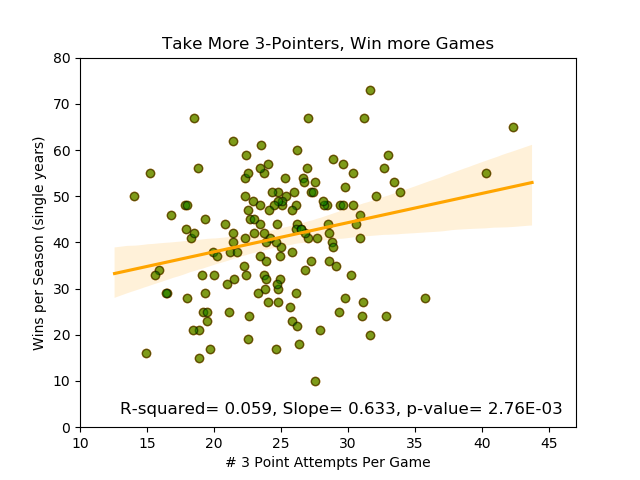

/anaconda3/envs/PythonUCB/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [15]:
#Graph relationship between 3P and wins
%matplotlib notebook

x = stacked_df["3PA"]
y = stacked_df["W"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox = f"R-squared= {r}, Slope= {slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x, y=y, color="orange")
plt.text(13,2.8,textbox, size='large', weight='light')
plt.scatter(x, y, marker="o", facecolors="green", edgecolors="black", alpha=0.5)

#Edit plot graph
plt.title("Take More 3-Pointers, Win more Games")
plt.xlabel("# 3 Point Attempts Per Game")
plt.ylabel("Wins per Season (single years)")
plt.xlim(10, 47)
plt.ylim(0, 80)

#Show ad save figure
plt.savefig("./Figures/S2F4_3PA_Wins.png")
plt.show()

<IPython.core.display.Javascript object>


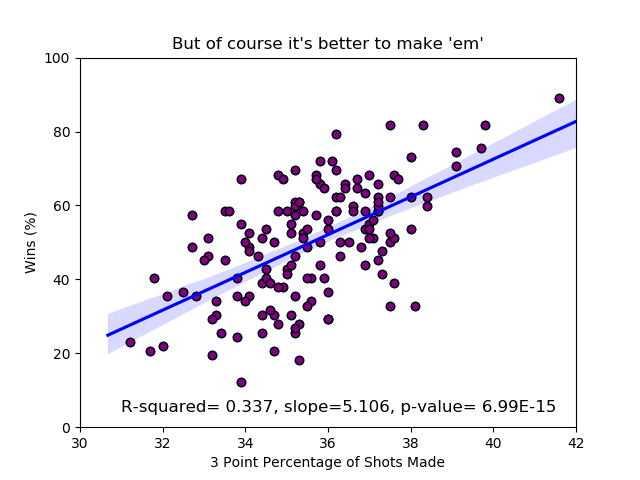

In [16]:
#Plot 3P shots and Win Percentage. Compute Linear regression
%matplotlib notebook

x = stacked_df["3P%"]
y = stacked_df["PctWin"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox = f"R-squared= {r}, slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x, y=y, data=stacked_df, color="blue")
plt.text(31,4,textbox, size='large', weight='light')
plt.scatter(x, y, marker="o", facecolors="purple", edgecolors="black", alpha=1)

#Edit graph
plt.title("But of course it's better to make 'em'")
plt.xlabel("3 Point Percentage of Shots Made")
plt.ylabel("Wins (%)")
plt.xlim(30, 42)
plt.ylim(0, 100)

#Show ad save figure
plt.savefig("./Figures/S2F5_3Pct_v_WPct.png")
plt.show()

## 3. Does Defense Win Games?

In [17]:
#Select Defense Data
sort_DRtg = stacked_df.sort_values(by='DRtg', ascending=False)
sort_nba_defense_df = sort_DRtg.sort_values(by='W', ascending=False)

<IPython.core.display.Javascript object>


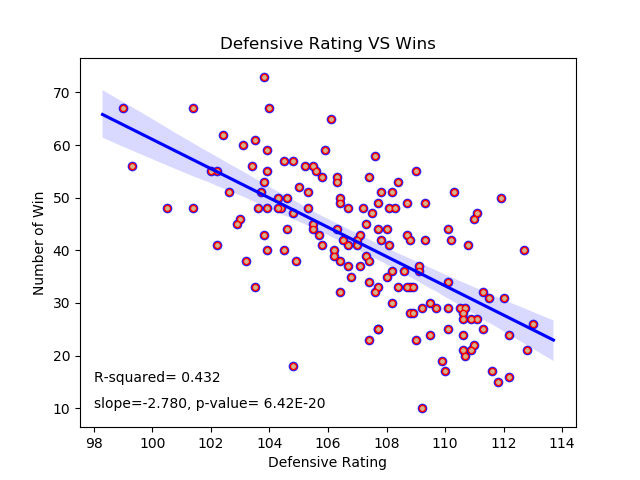

In [18]:
# Graph Defensive rating vs wins
%matplotlib notebook

x = sort_nba_defense_df["DRtg"]
y = sort_nba_defense_df["W"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
slp = "{:.3f}".format(slope)
r   = "{:.3f}".format(r_value**2)
pv  = "{:.2E}".format(p_value)
textbox1 = f"R-squared= {r}"
textbox2 = f"slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x, y=y, color="blue");
plt.text(98,15,textbox1, size='medium', weight='light')
plt.text(98,10,textbox2, size='medium', weight='light')
plt.scatter(x, y, marker="o", facecolors="tan", edgecolor="Red", s=20, alpha=1)

#Edit graph
plt.title("Defensive Rating VS Wins")
plt.xlabel("Defensive Rating")
plt.ylabel("Number of Win")

#Show ad save figure
plt.savefig("./Figures/S3F1_DefensiveRating.png")
plt.show()

In [19]:
#Defensive variables by team
block_steal = stacked_df[["Team","BLK","STL","DRB","W"]]
avg_block_steal = block_steal.groupby(["Team"])["BLK","STL","DRB","W"].mean()
avg_block_steal.head()

,BLK,STL,DRB,W
Team,,,,
Atlanta Hawks,4.700,8.50,32.760,42.60
Boston Celtics,4.120,7.88,32.900,44.20
Brooklyn Nets,4.280,7.32,32.640,30.20
Charlotte Bobcats,5.100,6.10,33.200,43.00
Charlotte Hornets,5.025,6.80,34.825,38.25


<IPython.core.display.Javascript object>


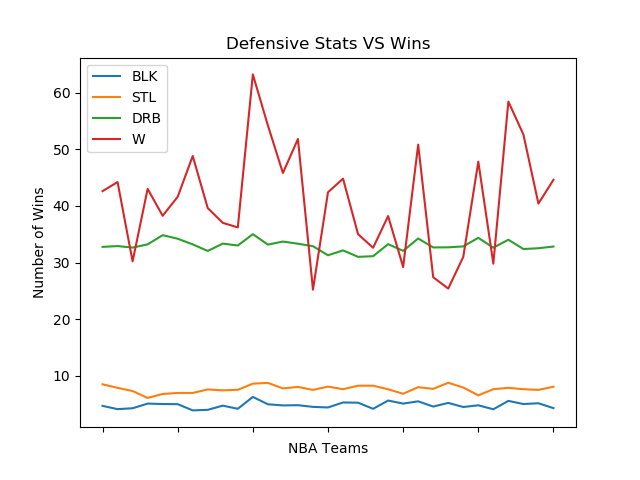

In [20]:
# Plot the world average as a line chart
%matplotlib notebook

#Plot the line
avg_block_steal.plot.line()

#Edit graph
plt.legend(loc="best")
plt.title("Defensive Stats VS Wins")
plt.xlabel("NBA Teams")
plt.ylabel("Number of Wins")

#Show ad save figure
plt.savefig("./Figures/S3F2_Defensestats.png")
plt.show()

In [21]:
#Defensive stats by year
defense_nba_complete_df=stacked_df[["Year", "STL", "BLK", "DRB","DRtg"]]  
avg_new_defense = defense_nba_complete_df.groupby(["Year"], as_index=False).mean()
print(avg_new_defense)

   Year       STL       BLK        DRB        DRtg
0  2014  7.686667  4.713333  31.836667  106.643333
1  2015  7.730000  4.793333  32.406667  105.650000
2  2016  7.840000  4.950000  33.343333  106.393333
3  2017  7.710000  4.740000  33.376667  108.780000
4  2018  7.713333  4.803333  33.806667  108.606667


<IPython.core.display.Javascript object>


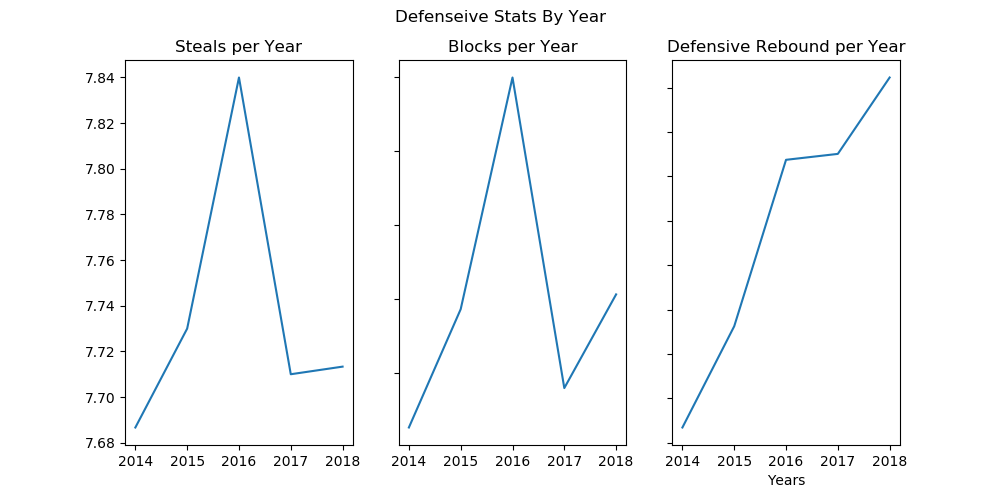

In [22]:
#plot defensive stats by year
fig, axarr = plt.subplots(1,3)
fig.set_size_inches(10,5)
fig.suptitle('Defenseive Stats By Year')
axarr[0].plot(avg_new_defense["Year"], avg_new_defense["STL"])
axarr[0].title.set_text('Steals per Year')
axarr[1].plot(avg_new_defense["Year"], avg_new_defense["BLK"])
axarr[1].title.set_text('Blocks per Year')
axarr[2].plot(avg_new_defense["Year"], avg_new_defense["DRB"])
axarr[2].title.set_text('Defensive Rebound per Year')
plt.xlabel("Years")
plt.ylabel("Numbers")

# Bring subplots close to each other.
fig.subplots_adjust(hspace=0)
# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()
    
plt.savefig("./Figures/S3F3_Defense_Stats_By_Year.png")
plt.show()

## 4. Team Performance Influence on Winning 

In [23]:
#Define a function to convert arrays to dataframes
def ArrayToDf(dat,**kwargs): 
  from numpy import array
  data = array(dat)
  if data is None or len(data)==0 or len(data[0])==0:
    return None
  else:
    return pd.DataFrame(data[0:,0:],**kwargs)

In [24]:
#Define our variables for PCA
pca_varlist = ["ph_3Ppct","ph_2Ppct","ph_FTpct","ph_AST","ph_STL","ph_BLK","ph_TOV","ph_PF","ph_shotmisspct"]

In [25]:
#Select columns from analytical data frame to compute the Principal Components
pca_df = stacked_df[pca_varlist]
pca_df.head()

,ph_3Ppct,ph_2Ppct,ph_FTpct,ph_AST,ph_STL,ph_BLK,ph_TOV,ph_PF,ph_shotmisspct
0,0.352,0.525,0.730,25.5,8.9,5.0,14.4,22.4,0.459413
1,0.358,0.529,0.712,22.1,7.8,5.8,16.6,21.1,0.460870
2,0.341,0.478,0.778,24.4,8.9,3.7,14.2,18.7,0.474936
3,0.372,0.481,0.815,24.3,5.8,4.9,14.3,20.1,0.472270
4,0.361,0.512,0.806,22.8,8.6,6.4,15.9,23.6,0.450980


In [26]:
#Standardize variables before performing PCA
pca_std = StandardScaler().fit_transform(pca_df)
pca_std

array([[-2.24484761e-01,  1.30965815e+00, -1.04839873e+00, ...,
        -4.34631826e-01,  9.13654718e-01, -1.34226569e+00],
       [ 1.20287056e-01,  1.49113503e+00, -1.65714638e+00, ...,
         1.52477395e+00,  6.40473265e-02, -1.24801536e+00],
       [-8.56566424e-01, -8.22695188e-01,  5.74928337e-01, ...,
        -6.12759624e-01, -1.50445863e+00, -3.37934072e-01],
       ...,
       [ 2.35210995e-01, -6.04922932e-03,  6.76386279e-02, ...,
        -1.85965421e+00, -6.54851236e-01,  1.22405207e+00],
       [-2.24484761e-01, -4.59741428e-01,  8.45482849e-01, ...,
         7.23198858e-01,  2.22074301e+00,  3.66140977e-01],
       [ 1.09714054e+00, -7.77325968e-01, -8.79302163e-01, ...,
        -4.34631826e-01, -1.30708830e-03,  1.49348837e+00]])

In [27]:
#Perform PCA using 6 components
pca = PCA(n_components=6)
pca.fit(pca_std)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

<IPython.core.display.Javascript object>


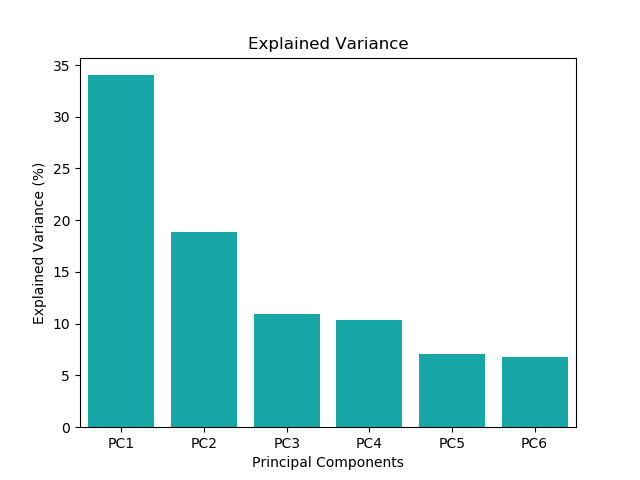

In [28]:
#Explained variance
%matplotlib notebook
df = pd.DataFrame({"Explained Variance (%)":(pca.explained_variance_ratio_)*100,"Principal Components":["PC1","PC2","PC3","PC4","PC5","PC6"]})
sns.barplot(x="Principal Components",y="Explained Variance (%)", data=df, color="c")

#Edit Graph
plt.title("Explained Variance")

#Show ad save figure
plt.savefig("./Figures/S4F1_Explained_Variance.png")
plt.show()

In [29]:
#Get the coefficient table
pca_coeff = pca.components_
cdf = ArrayToDf(pca_coeff)
coeff_df = cdf.T
coeff_df.columns =["Coeff PC1","Coeff PC2","Coeff PC3","Coeff PC4","Coeff PC5","Coeff PC6"]
coeff_df=coeff_df[["Coeff PC1"]]

coeff_df["Variables"]=pca_varlist
coeff_df

,Coeff PC1,Variables
0,0.425849,ph_3Ppct
1,0.447285,ph_2Ppct
2,0.295274,ph_FTpct
3,0.422073,ph_AST
4,0.076603,ph_STL
5,0.176549,ph_BLK
6,-0.148378,ph_TOV
7,-0.235753,ph_PF
8,-0.488491,ph_shotmisspct


In [30]:
#Apply the scores to original data and calculate the vector of components
pca_scs = pca.transform(pca_std)

#Convert array of scores to dataframe
pc1_df = ArrayToDf(pca_scs)
pc1_df.columns =["PC1","PC2","PC3","PC4","PC5","PC6"]
pc1_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,1.256393,-1.522899,-1.056217,-0.136804,0.492220,0.582643
1,0.479560,-1.751128,0.287187,0.894060,0.323303,2.256398
2,0.072730,1.032371,-1.785916,-0.725802,0.362191,-1.571680
3,1.085898,2.532370,1.755744,-0.446318,-1.277320,-0.058520
4,1.534919,-1.917977,2.269131,-1.251388,1.070946,0.179341


In [31]:
#Merge PCA scores with orignal dataset
main_df = stacked_df[["Team","Year","PctWin","ph_3Ppct","ph_2Ppct","ph_FTpct","ph_AST",
                      "ph_STL","ph_BLK","ph_TOV","ph_PF","ph_shotmisspct"]]
nba_pca_df = main_df.join(pc1_df)
nba_pca_df.to_csv("./Output_data/nba_PCA_results.csv")
nba_pca_df.head()

,Team,Year,PctWin,ph_3Ppct,ph_2Ppct,ph_FTpct,ph_AST,ph_STL,ph_BLK,ph_TOV,ph_PF,ph_shotmisspct,PC1,PC2,PC3,PC4,PC5,PC6
0,Los Angeles Clippers,2014,69.512195,0.352,0.525,0.730,25.5,8.9,5.0,14.4,22.4,0.459413,1.256393,-1.522899,-1.056217,-0.136804,0.492220,0.582643
1,Houston Rockets,2014,65.853659,0.358,0.529,0.712,22.1,7.8,5.8,16.6,21.1,0.460870,0.479560,-1.751128,0.287187,0.894060,0.323303,2.256398
2,Minnesota Timberwolves,2014,48.780488,0.341,0.478,0.778,24.4,8.9,3.7,14.2,18.7,0.474936,0.072730,1.032371,-1.785916,-0.725802,0.362191,-1.571680
3,Portland Trail Blazers,2014,65.853659,0.372,0.481,0.815,24.3,5.8,4.9,14.3,20.1,0.472270,1.085898,2.532370,1.755744,-0.446318,-1.277320,-0.058520
4,Oklahoma City Thunder,2014,71.951220,0.361,0.512,0.806,22.8,8.6,6.4,15.9,23.6,0.450980,1.534919,-1.917977,2.269131,-1.251388,1.070946,0.179341


In [32]:
#Select last Season data
nba_pca_last = nba_pca_df.loc[nba_pca_df["Year"]==2018]
nba_pca_last = nba_pca_last[["Team", "PC1"]]
nba_pca_last = nba_pca_last.sort_values("PC1")
nba_pca_last = nba_pca_last.reset_index(drop=True)
nba_pca_last

,Team,PC1
0,Phoenix Suns,-2.206578
1,Chicago Bulls,-1.191153
2,Sacramento Kings,-1.092028
3,Memphis Grizzlies,-0.993420
4,Los Angeles Lakers,-0.693914
5,Oklahoma City Thunder,-0.693645
6,Dallas Mavericks,-0.329234
7,Brooklyn Nets,-0.246796
8,Detroit Pistons,-0.152797
9,Orlando Magic,0.027029


<IPython.core.display.Javascript object>


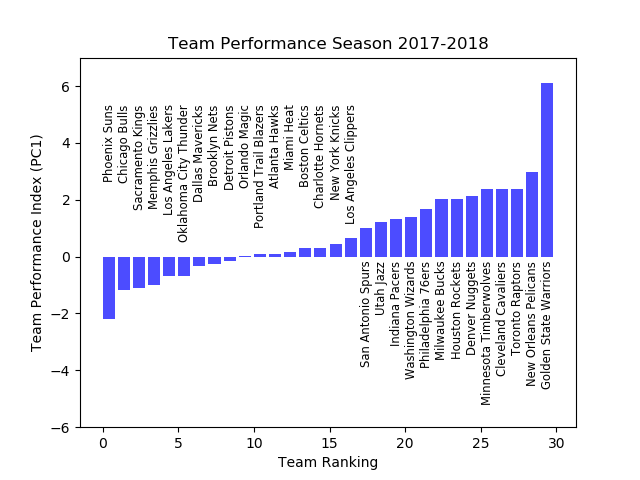

In [33]:
#Plot ranking of teams based of Team Performance
%matplotlib notebook

#Get axis and ticks
team_list = list(nba_pca_last["Team"])
ybar = list(nba_pca_last["PC1"])
xbar = np.arange(len(ybar))

#Get Tick locations
tick_locations = [value for value in xbar]

# Make the graph
plt.bar(xbar, ybar, align="edge", color="blue", alpha=0.70)
for i in range(len(ybar)):
    if i > 16:
        label_position = -0.5
    else:
        label_position = 5
    plt.text(x = xbar[i], y = label_position, s=team_list[i], rotation=90, size="small")

#Edit plot
plt.ylim(-6, 7)
plt.title("Team Performance Season 2017-2018")
plt.ylabel("Team Performance Index (PC1)")
plt.xlabel("Team Ranking")

#Show ad save figure
plt.savefig("./Figures/S4F2_Team_Ranking.png")
plt.show()

<IPython.core.display.Javascript object>


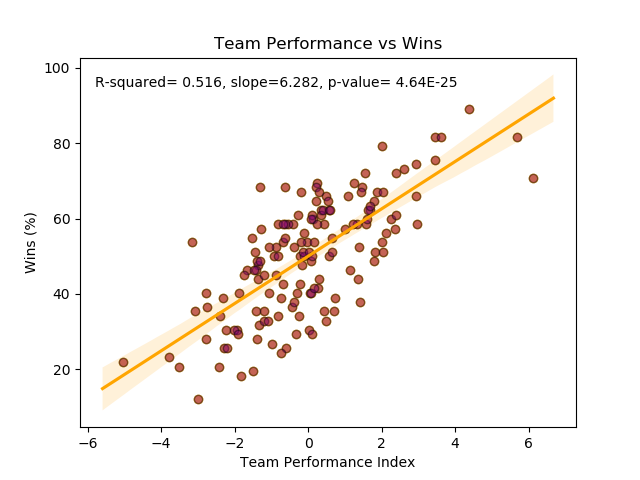

/anaconda3/envs/PythonUCB/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [34]:
#Graph relationship between Team Performance and Wins
%matplotlib notebook

x_axis = nba_pca_df["PC1"]
y_axis = nba_pca_df["PctWin"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis,y_axis)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox = f"R-squared= {r}, slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x_axis, y=y_axis, data=nba_pca_df, color="orange")
plt.text(-5.8,95,textbox, size='medium', weight='light')
plt.scatter(x_axis, y_axis, marker="o", facecolors="purple", edgecolors="black", alpha=0.45)

#Edit plot graph
plt.title("Team Performance vs Wins")
plt.xlabel("Team Performance Index")
plt.ylabel("Wins (%)")

#Show ad save figure
plt.savefig("./Figures/S4F3_Performance_vs_Wins.png")
plt.show()

## 5. Modern Day NBA Offenses: More 3s, less mid range shots

In [35]:
#Preliminary data work
pct_fga_advanced_merge = pd.merge(sorted_mid_range_df, sorted_advanced_df)

<IPython.core.display.Javascript object>


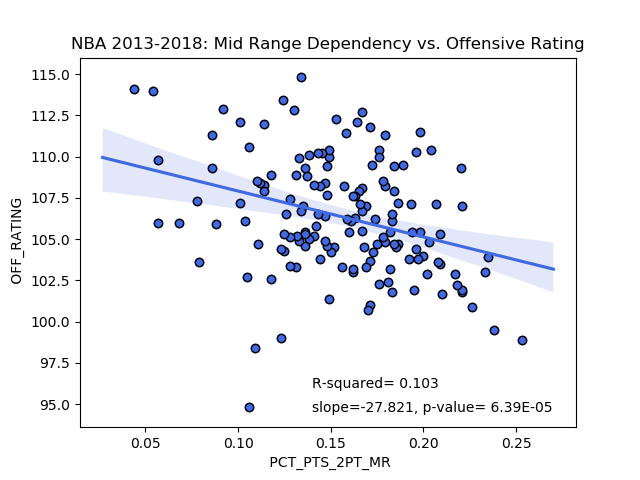

In [36]:
#Mid Range Dependency vs Offensive rating
%matplotlib notebook

x_axis = pct_fga_advanced_merge[" PCT_PTS_2PT_MR"]
y_axis = pct_fga_advanced_merge[" OFF_RATING"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox1 = f"R-squared= {r}"
textbox2 = f"slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x_axis, y=y_axis, data=nba_pca_df, color="royalblue")
plt.scatter(x_axis, y_axis, marker="o", facecolors="royalblue", edgecolors="black", alpha=1)
plt.text(0.14,96,textbox1, size='medium', weight='light', fontsize=10)
plt.text(0.14,94.5,textbox2, size='medium', weight='light', fontsize=10)

#Edit
plt.title("NBA 2013-2018: Mid Range Dependency vs. Offensive Rating")

#Show ad save figure
plt.savefig("./Figures/S5F1_Midrange_vs_Rating.png")
plt.show()

<IPython.core.display.Javascript object>


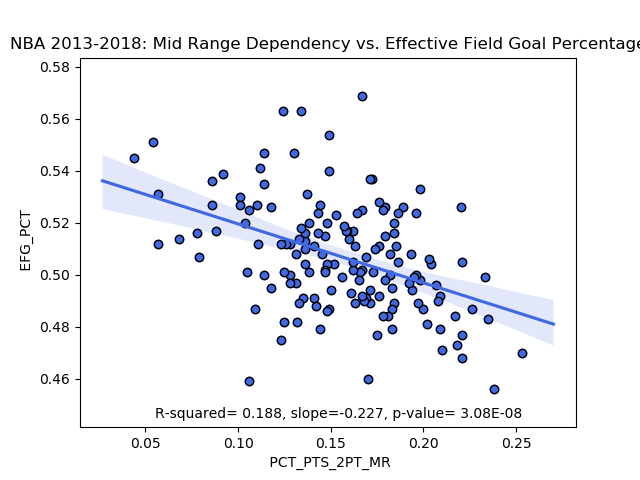

In [37]:
#Mid range dependency vs effective field goal percentage
%matplotlib notebook

x_axis = pct_fga_advanced_merge[" PCT_PTS_2PT_MR"]
y_axis = pct_fga_advanced_merge[" EFG_PCT"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox = f"R-squared= {r}, slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x_axis, y=y_axis, data=nba_pca_df, color="royalblue")
plt.scatter(x_axis, y_axis, marker="o", facecolors="royalblue", edgecolors="black", alpha=1)
plt.text(0.055,0.445,textbox, size='medium', weight='light', fontsize=10)


#Edit
plt.title("NBA 2013-2018: Mid Range Dependency vs. Effective Field Goal Percentage")

#Show ad save figure
plt.savefig("./Figures/S5F2_Midrange_vs_Effective_Field_Goal.png")
plt.show()

<IPython.core.display.Javascript object>


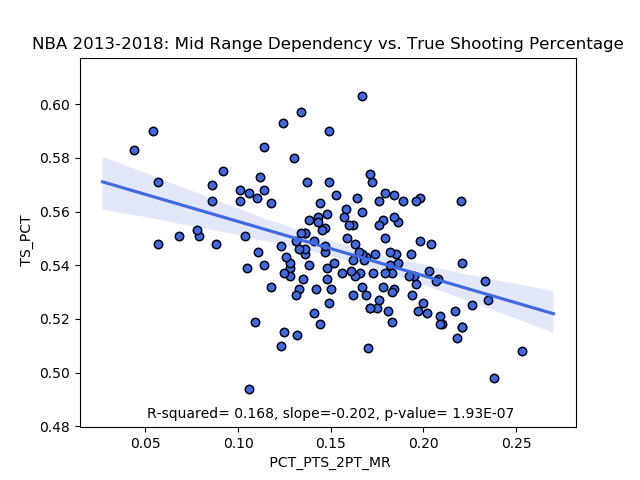

In [38]:
#Mid range dependency vs true shooting percentage
%matplotlib notebook

x_axis = pct_fga_advanced_merge[" PCT_PTS_2PT_MR"]
y_axis = pct_fga_advanced_merge[" TS_PCT"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox = f"R-squared= {r}, slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x_axis, y=y_axis, data=nba_pca_df, color="royalblue")
plt.scatter(x_axis, y_axis, marker="o", facecolors="royalblue", edgecolors="black", alpha=1)
plt.text(0.051,0.483,textbox, size='medium', weight='light', fontsize=10)


#Edit
plt.title("NBA 2013-2018: Mid Range Dependency vs. True Shooting Percentage")

#Show ad save figure
plt.savefig("./Figures/S5F3_Midrange_vs_True_Shooting.png")
plt.show()


In [39]:
#Merge FG and Advance data
mid_fga_advanced_merge = pd.merge(sorted_location_df, sorted_advanced_df)
mid_fga_advanced_merge.head()

,TEAM_NAME,MID_FGA,MID FGA/FGA,LA MID FGA/FGA,OFF_RATING,EFG_PCT,TS_PCT,League Average OffRating
0,2015 New York Knicks,29.1,0.355746,0.262125,98.9,0.470,0.508,104.713333
1,2015 Washington Wizards,28.9,0.350303,0.262125,103.0,0.499,0.534,104.713333
2,2015 Minnesota Timberwolves,28.9,0.347774,0.262125,101.8,0.468,0.517,104.713333
3,2015 Los Angeles Lakers,29.2,0.341520,0.262125,102.2,0.473,0.513,104.713333
4,2015 Charlotte Hornets,28.6,0.338863,0.262125,99.5,0.456,0.498,104.713333


<IPython.core.display.Javascript object>


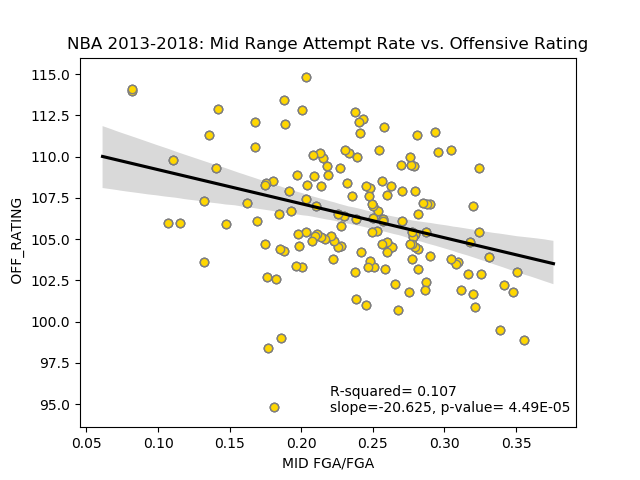

In [41]:
#Mid range attempt rate vs offensive rating
%matplotlib notebook

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox1 = f"R-squared= {r}"
textbox2 = f"slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x_axis, y=y_axis, data=nba_pca_df, color="black")
x_axis = mid_fga_advanced_merge["MID FGA/FGA"]
y_axis = mid_fga_advanced_merge[" OFF_RATING"]


plt.scatter(x_axis, y_axis, marker="o", facecolors="gold", edgecolors="grey", alpha=1)
plt.text(0.22,95.5,textbox1, size='medium', weight='light', fontsize=10)
plt.text(0.22,94.5,textbox2, size='medium', weight='light', fontsize=10)

#Edit
plt.title("NBA 2013-2018: Mid Range Attempt Rate vs. Offensive Rating")

#Show ad save figure
plt.savefig("./Figures/S5F4_Midrange_Attempt_vs_Offensive_Rating.png")
plt.show()


<IPython.core.display.Javascript object>


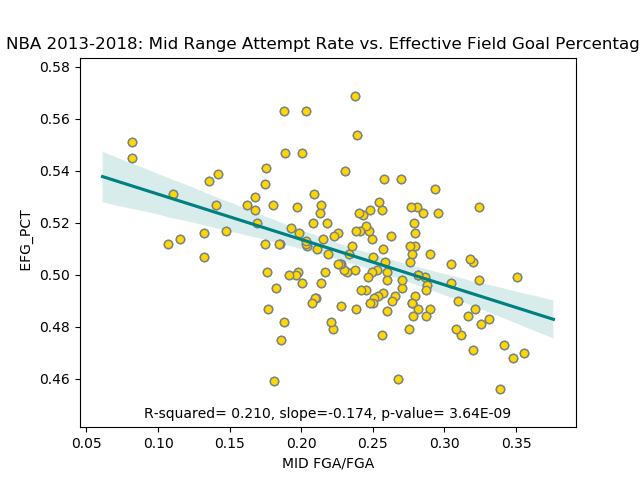

In [42]:
#Mid range attempt rate vs Effective Field goal Percentage
%matplotlib notebook

x_axis = mid_fga_advanced_merge["MID FGA/FGA"]
y_axis = mid_fga_advanced_merge[" EFG_PCT"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox = f"R-squared= {r}, slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x_axis, y=y_axis, data=nba_pca_df, color="teal")
plt.scatter(x_axis, y_axis, marker="o", facecolors="gold", edgecolors="grey", alpha=1)
plt.text(0.09,0.445,textbox, size='medium', weight='light', fontsize=10)

#Edit
plt.title("NBA 2013-2018: Mid Range Attempt Rate vs. Effective Field Goal Percentage")

#Show ad save figure
plt.savefig("./Figures/S5F5_Midrange_Attempt_vs_Effective_Field_Goal.png")
plt.show()

<IPython.core.display.Javascript object>


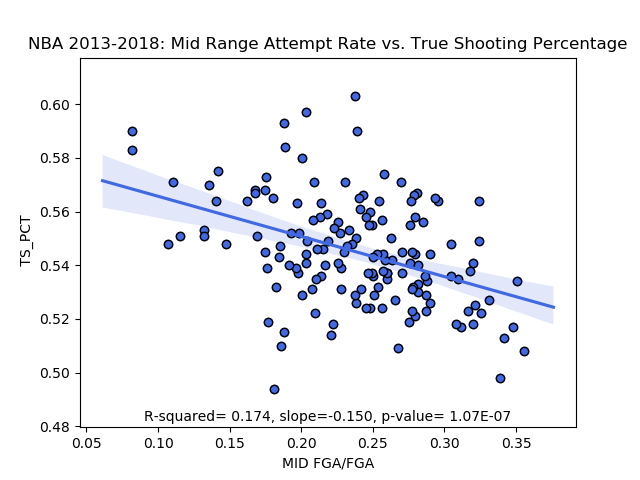

In [43]:
#Mid range attempt rate vs True Shooting Percentage
%matplotlib notebook

x_axis = mid_fga_advanced_merge["MID FGA/FGA"]
y_axis = mid_fga_advanced_merge[" TS_PCT"]

#Fit regression lines
slope, intercept, r_value, p_value, std_err = stats.linregress(x_axis, y_axis)
r   = "{:.3f}".format(r_value**2)
slp = "{:.3f}".format(slope)
pv  = "{:.2E}".format(p_value)
textbox = f"R-squared= {r}, slope={slp}, p-value= {pv}"

#Plot scatterplot and regression line
sns.regplot(x=x_axis, y=y_axis, data=nba_pca_df, color="royalblue")
plt.scatter(x_axis, y_axis, marker="o", facecolors="royalblue", edgecolors="black", alpha=1)
plt.text(0.09,0.482,textbox, size='medium', weight='light', fontsize=10)

#Edit
plt.title("NBA 2013-2018: Mid Range Attempt Rate vs. True Shooting Percentage")

#Show ad save figure
plt.savefig("./Figures/S5F6_Midrange_Attempt_vs_True_Shooting.png")
plt.show()

In [44]:
#mid_range_attempt_rate vs. mid_range_dependency
mid_range_df = pd.merge(sorted_mid_range_df, sorted_location_df)
mid_range_df.head()

,TEAM_NAME,PCT_PTS_2PT_MR,MID_FGA,MID FGA/FGA,LA MID FGA/FGA
0,2015 New York Knicks,0.253,29.1,0.355746,0.262125
1,2015 Charlotte Hornets,0.238,28.6,0.338863,0.262125
2,2016 New York Knicks,0.235,27.8,0.331347,0.246650
3,2015 Washington Wizards,0.233,28.9,0.350303,0.262125
4,2014 Orlando Magic,0.226,26.5,0.321212,0.268580


<IPython.core.display.Javascript object>


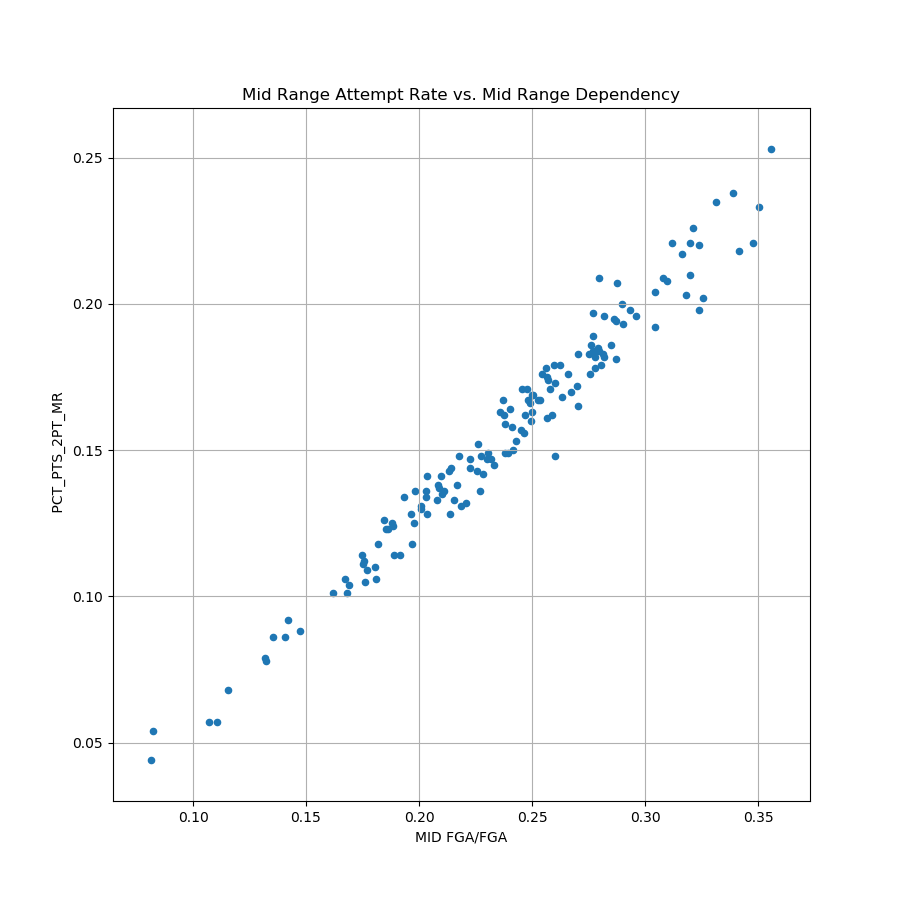

In [45]:
#Graph Mid Range Attempt rate vs Mid Range dependency
%matplotlib notebook

mid_range_df.plot(kind='scatter', x="MID FGA/FGA", y=" PCT_PTS_2PT_MR", grid=True, figsize=(9,9), 
                       title="Mid Range Attempt Rate vs. Mid Range Dependency")

plt.savefig("./Figures/S5F7_Midrange_Attempt_vs_Mid_Range_Dependency.png")
plt.show()

In [46]:
#Combine sdata from last 5 seasons
seasons = ["2013-14", "2014-15", "2015-16", "2016-17", "2017-18"]
last5_nba_seasons = [locdf_list["loca_2014"]["MID FGA/FGA"].mean(), 
                     locdf_list["loca_2015"]["MID FGA/FGA"].mean(), 
                     locdf_list["loca_2016"]["MID FGA/FGA"].mean(), 
                     locdf_list["loca_2017"]["MID FGA/FGA"].mean(),
                     locdf_list["loca_2018"]["MID FGA/FGA"].mean()]

<IPython.core.display.Javascript object>


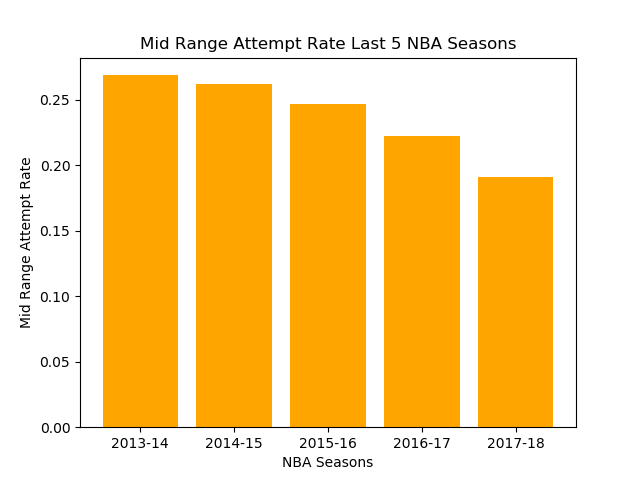

In [47]:
#Mid Range Attempt Rate Last 5 NBA Seasons
%matplotlib notebook
plt.bar(seasons, last5_nba_seasons, color="orange", align="center")
plt.title("Mid Range Attempt Rate Last 5 NBA Seasons")
plt.xlabel("NBA Seasons")
plt.ylabel("Mid Range Attempt Rate")
plt.savefig("./Figures/S5F8_Midrange_Attempt_Rate_5season.png")
plt.show()

In [48]:
#Combine sdata from last 5 seasons
last5_nba_offrating = [advdf_list["adv_2014"][" OFF_RATING"].mean(), 
                       advdf_list["adv_2015"][" OFF_RATING"].mean(), 
                       advdf_list["adv_2016"][" OFF_RATING"].mean(), 
                       advdf_list["adv_2017"][" OFF_RATING"].mean(),
                       advdf_list["adv_2018"][" OFF_RATING"].mean()]

<IPython.core.display.Javascript object>


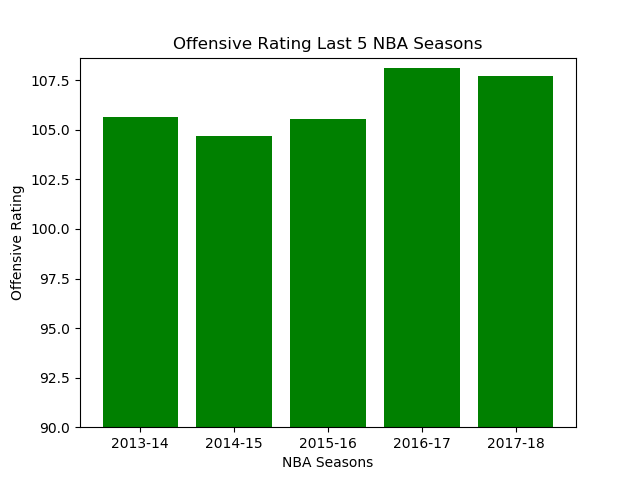

In [49]:
#Offensive Rating Last 5 NBA Seasons
%matplotlib notebook

plt.bar(seasons, last5_nba_offrating, color="green", align="center")
plt.title("Offensive Rating Last 5 NBA Seasons")
plt.xlabel("NBA Seasons")
plt.ylabel("Offensive Rating")
plt.ylim(90, max(last5_nba_offrating)+0.5)
plt.savefig("./Figures/S5F9_Offensive_Rate_5season.png")
plt.show()

In [50]:
#Combine sdata from last 5 seasons
last5_efg  = [advdf_list["adv_2014"][" EFG_PCT"].mean(), 
              advdf_list["adv_2015"][" EFG_PCT"].mean(), 
              advdf_list["adv_2016"][" EFG_PCT"].mean(), 
              advdf_list["adv_2017"][" EFG_PCT"].mean(),
              advdf_list["adv_2018"][" EFG_PCT"].mean()]

<IPython.core.display.Javascript object>


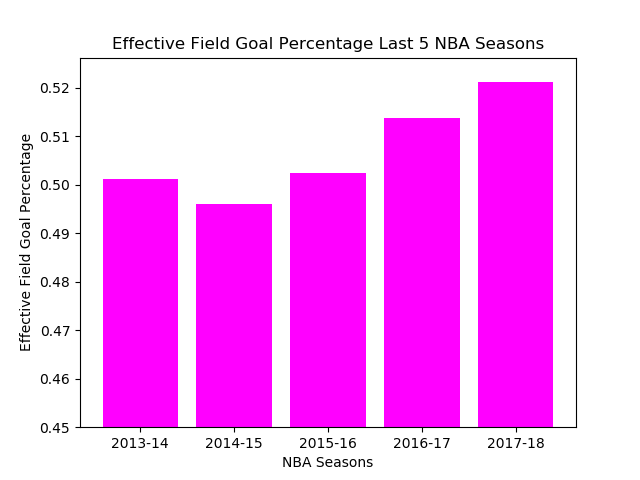

In [51]:
#Effective Field Goal Percentage Last 5 NBA Seasons
%matplotlib notebook

plt.bar(seasons, last5_efg, color="magenta", align="center")
plt.title("Effective Field Goal Percentage Last 5 NBA Seasons")
plt.xlabel("NBA Seasons")
plt.ylabel("Effective Field Goal Percentage")

plt.ylim(0.45, max(last5_efg)+0.005)

plt.savefig("./Figures/S5F10_Effective_Field_Goal_5season.png")
plt.show()

In [52]:
#Combine sdata from last 5 seasons
last5_ts  = [advdf_list["adv_2014"][" TS_PCT"].mean(), 
              advdf_list["adv_2015"][" TS_PCT"].mean(), 
              advdf_list["adv_2016"][" TS_PCT"].mean(), 
              advdf_list["adv_2017"][" TS_PCT"].mean(),
              advdf_list["adv_2018"][" TS_PCT"].mean()]

<IPython.core.display.Javascript object>


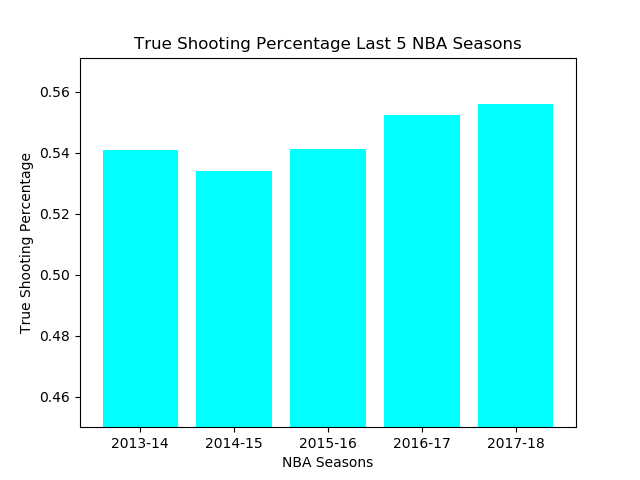

In [53]:
#True Shooting Percentage Last 5 NBA Seasons
%matplotlib notebook

plt.bar(seasons, last5_ts, color="cyan", align="center")
plt.title("True Shooting Percentage Last 5 NBA Seasons")
plt.xlabel("NBA Seasons")
plt.ylabel("True Shooting Percentage")

plt.ylim(0.45, max(last5_efg)+0.05)

plt.savefig("./Figures/S5F11_true_Shooting_5season.png")
plt.show()

# END OF NOTEBOOK